In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing

np.set_printoptions(suppress=True)

In [13]:
class LabelEncoder:
    
    def __init__(self, num_points):
        self.num_points = num_points
    
    def encode(self, chromatogram, locs, scales, asymmetries):

        for loc, scale, asymmetry in zip(locs, scales, asymmetries):
            left = np.clip(int((loc-3.5*scale*(1-asymmetry*3.5)) * self.num_points), 0, self.num_points)
            right = np.clip(int((loc+3.5*scale*(1+asymmetry*3.5)) * self.num_points), 0, self.num_points)
            
        left /= self.num_points
        right /= self.num_points
        
        return [left, right]
            
    def decode(self, predictions, threshold=0.5):
        left = int(predictions[0] * self.num_points)
        right = int(predictions[1] * self.num_points)
        return [left, right]

encoder = LabelEncoder(2048)


In [3]:
def asymmetrical_gaussian_peak(x, amplitude, loc, scale, asymmetry):
    # assymetrical_gaussian_peak(..., assymetry=0) is the same as gaussian_peak(...)
    return amplitude * np.exp(-1/2*((x - loc)/(scale + asymmetry*(x - loc)))**2)

def generate_example(_):
    np.random.seed(_)
    t = np.linspace(0, 1, 2048)
    loc = np.random.uniform(0.35, 0.65)
    scale = np.random.uniform(0.025, 0.03)
    amplitude = np.random.uniform(8, 15)
    asymmetry = np.random.uniform(0.0, 0.2)

    g = asymmetrical_gaussian_peak(t, amplitude, loc, scale, asymmetry)

    g += np.random.randn(g.shape[0]) * np.random.uniform(0, .1)
    g += np.random.uniform(-.50, .50)
    g += np.linspace(0, 1, len(g)) * np.random.uniform(-.50, .50)
    y = encoder.encode(g, [loc], [scale], [asymmetry])
    
    return g, y

with multiprocessing.Pool() as pool:
    data = [i for i in tqdm(pool.imap(generate_example, range(500)), total=500)]
    

y = np.stack([d[1] for d in data])
X = np.stack([d[0] for d in data])[..., None]
t = np.linspace(0, 1, 2048)


  0%|          | 0/500 [00:00<?, ?it/s]

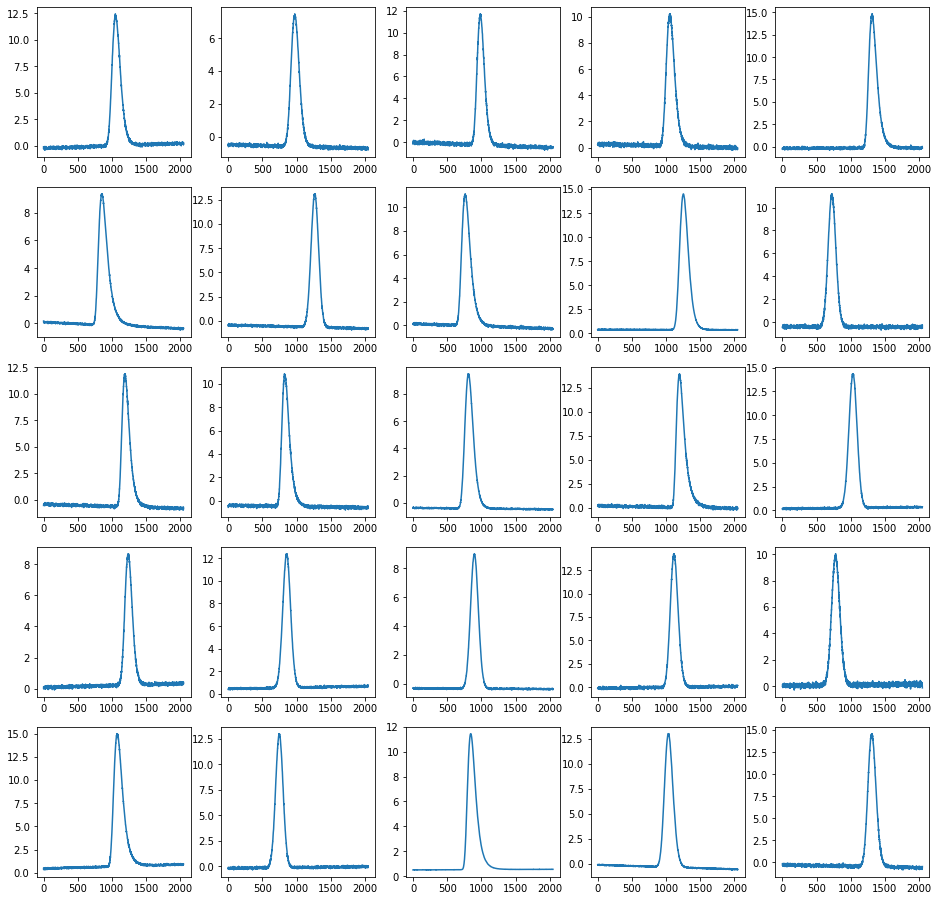

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16))

for x, ax in zip(X[:], axes.reshape(-1)):
    
    ax.plot(x[:, 0])

In [5]:
from tensorflow.keras import layers


def conv_block(x, filters, kernel_size, stride, batch_norm=True, training=False):
    x = layers.Conv1D(filters, kernel_size, stride, padding='same')(x, training=training)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x, training=training)
    return x

def encoder_block(x, filters, kernel_size, stride, pool_size=2, training=False):
    x = conv_block(x, filters, kernel_size, stride, training=training)
    x = tf.keras.layers.MaxPool1D()(x)
    return x

def UNet():
    
    inputs = layers.Input((2048, 1), dtype='float32')
    x = inputs
    
    x = encoder_block(x, 64, 9, 1)
    x = encoder_block(x, 128, 9, 1)
    x = encoder_block(x, 128, 9, 1)
    x = encoder_block(x, 256, 9, 1)
    x = encoder_block(x, 256, 9, 1)
    
    x = layers.Flatten()(x)
    
    #x = layers.Dropout(0.2)(x, training=True)
    x = layers.Dense(1024, activation='relu')(x)
    #x = layers.Dropout(0.2)(x, training=True)
   # x = layers.Dense(1024, activation='relu')(x)
   # x = layers.Dropout(0.1)(x, training=True)
    
    x = layers.Dense(2, activation='relu')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
        

In [6]:
model = UNet()
model.summary()

2021-10-11 16:53:31.280414: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-11 16:53:31.280443: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 16:53:31.280465: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alex): /proc/driver/nvidia/version does not exist
2021-10-11 16:53:31.280719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-11 16:53:31.315083: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 260000000

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2048, 64)          640       
_________________________________________________________________
activation (Activation)      (None, 2048, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1024, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 128)         73856     
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 128)        

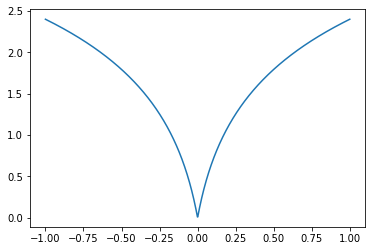

In [7]:
x = np.linspace(-1, 1, 1000)

def f(x):
    return abs(x)

def g(x):
    return np.log1p(abs(x) * 10 + 1e-7) 

def h(x):
    return g(x) + f(x)

#plt.plot(x, f(x))

plt.plot(x, g(x))

#plt.plot(x, h(x))

In [8]:
model = UNet()


def loss(y_true, y_pred, sample_weight=None):
    
    return tf.math.log1p(tf.math.abs(y_true - y_pred) * 10)

model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(3e-4))
model.fit(X[:490], y[:490], epochs=10, batch_size=32, verbose=1)
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X[:490], y[:490], epochs=10, batch_size=32, verbose=1)
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X[:490], y[:490], epochs=10, batch_size=32, verbose=1)

Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.2548
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.7050
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.5841
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.3966
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.3459
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.3121
Epoch 7/10
8/8 [==============================] - 10s 1s/step - loss: 0.2484
Epoch 8/10
8/8 [==============================] - 9s 1s/step - loss: 0.2426
Epoch 9/10
8/8 [==============================] - 9s 1s/step - loss: 0.1829
Epoch 10/10
8/8 [==============================] - 9s 1s/step - loss: 0.1913
Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: 0.1663
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.1406
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.1348
Ep

KeyboardInterrupt: 

In [10]:
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X[:490], y[:490], epochs=10, batch_size=32, verbose=1)

Epoch 1/10
16/16 [==============================] - 11s 690ms/step - loss: 0.1293
Epoch 2/10
16/16 [==============================] - 10s 648ms/step - loss: 0.1216
Epoch 3/10
16/16 [==============================] - 10s 640ms/step - loss: 0.1171
Epoch 4/10
16/16 [==============================] - 10s 642ms/step - loss: 0.1135
Epoch 5/10
16/16 [==============================] - 10s 640ms/step - loss: 0.1124
Epoch 6/10
16/16 [==============================] - 10s 646ms/step - loss: 0.1069
Epoch 7/10
16/16 [==============================] - 10s 647ms/step - loss: 0.1059
Epoch 8/10
16/16 [==============================] - 10s 646ms/step - loss: 0.1036
Epoch 9/10
16/16 [==============================] - 10s 646ms/step - loss: 0.0985
Epoch 10/10
16/16 [==============================] - 10s 651ms/step - loss: 0.0955


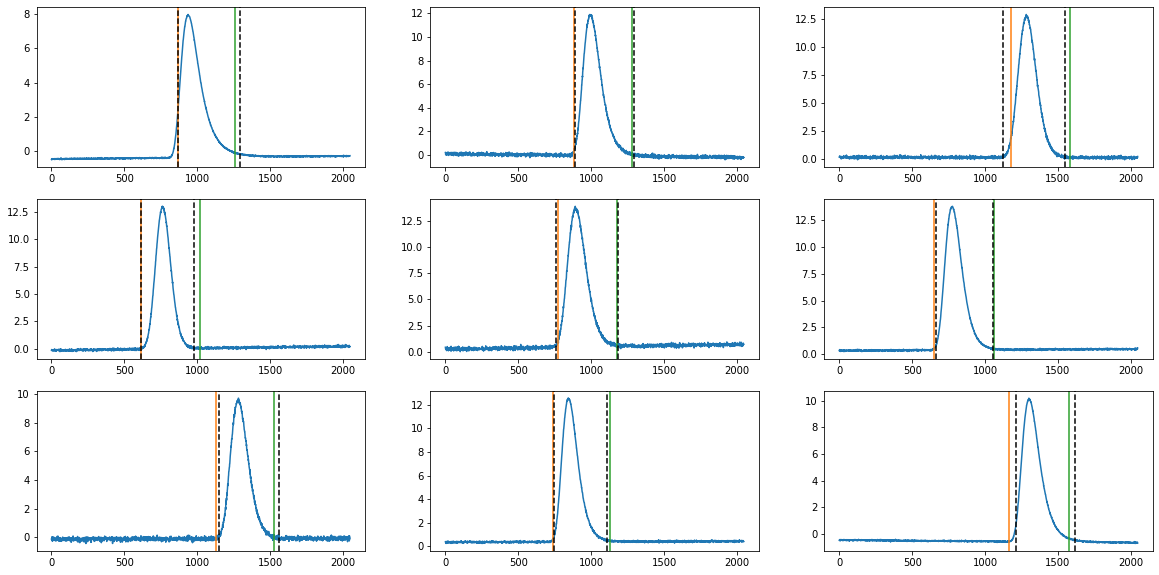

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, ax in enumerate(axes.reshape(-1)):
    
    left, right = 0, 0
    for _ in range(1):
        
        x = X[491 + i][None].copy()
        
      #  x += np.random.randn(x.shape[0]) * np.random.uniform(0, .01)
       # x *= np.random.uniform(0.95, 1.05)
       # x += np.linspace(0, 1, len(x)) * np.random.uniform(-.050, .050)
        
        out = model.predict(x)[0]
        
        left += out[0] / 1
        right += out[1]/ 1
    
    prediction = [left, right]
        
    left, right = encoder.decode(prediction)

    ax.plot(X[491+i])
    ax.axvline(left, color='C1')
    ax.axvline(right, color='C2')

    left, right = encoder.decode(y[491+i])

    ax.axvline(left, color='black', linestyle='--')
    ax.axvline(right, color='black', linestyle='--')
    
    

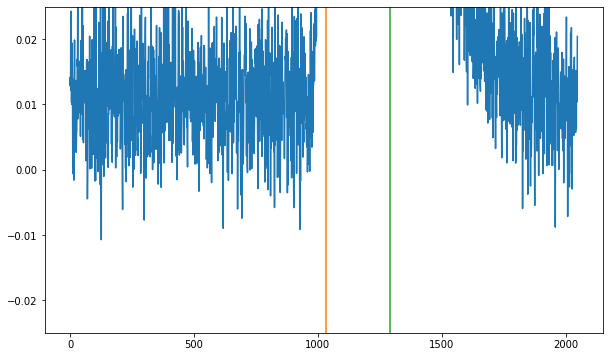

In [176]:
plt.figure(figsize=(10, 6))

prediction = model.predict(X[ID][None])[0]
left, right = encoder.decode(prediction)

plt.ylim(-0.025, 0.025)
plt.plot(X[ID])
plt.axvline(left, color='C1')
plt.axvline(right, color='C2')